In [1]:
from imports.ExtractContactCases import ExtractContactCases, cases_dict

ex = ExtractContactCases('contact_extraction1', bag_file_name='../dataset_ENVTACT_new2.bag', max_events_thresh=10000)


In [2]:
samples = ex.load()
len(samples)

644

In [3]:
import numpy as np

In [4]:
import numpy as np
import torch

import torch_geometric.transforms as T
from torch_geometric.nn.pool import radius_graph, knn_graph
from torch_geometric.data import Data
from torch_geometric import seed_everything
from torch_geometric.utils import to_undirected


seed_everything(0)

im_height=260
im_width=346

def make_graph_(events, case):
    
    coords = events[:, 0:2] - np.array([157, 122])
    coords = torch.tensor(coords.astype(np.float32))
    
    coord1, coord2 = coords.T
    
    #ts = (events[:, 2] - events[0, 2]).astype(np.float32)
    #ts = ts*5e-6
    
    
    #coord3 = torch.tensor(ts)
    #pos = torch.stack((coord1 , coord2 , coord3)).T
    
    
    ts = events[:, 2]
    ts = ((ts - ts.min()) / (ts.max() - ts.min())).astype(np.float32)
    coord3 = torch.tensor(ts)
    pos = torch.stack((coord1 , coord2 , coord3)).T
    
    r = torch.norm(coords, dim=-1)
    theta = torch.atan2(coords[:,1], coords[:,0])
    
    feature = torch.stack((r, theta, coord3))
    #feature = feature.T / torch.max(feature,dim=-1)[0]

    feature = torch.hstack((
            feature.T / torch.max(feature,dim=-1)[0].T,
            torch.tensor((2*events[:, 3] - 1).astype(np.float32)).reshape(-1, 1)
            ))


    edge_index = to_undirected(knn_graph(pos, 16, loop=True))
    row, col = edge_index
    
    edge_attr = feature[row, :-1] - feature[col, :-1]
    
    max_value = edge_attr.abs().max() 
    edge_attr = edge_attr / (2 * max_value) + 0.5
    
    y = torch.tensor(np.array(cases_dict[case], dtype=np.float32)).reshape(1, -1)

    data = Data(x=feature, edge_index=edge_index, pos=pos, y=y, edge_attr=edge_attr)
    
    return data


def make_graph(events, case, features='all'):
    coord1, coord2 = torch.tensor(events[:, 0:2].astype(np.float32)).T 
    ts = events[:, 2]
    ts = ((ts - ts.min()) / (ts.max() - ts.min())).astype(np.float32)
    coord3 = torch.tensor(ts)
    pos = torch.stack((coord1 / im_width, coord2 / im_height, coord3)).T

    if features == 'pol':
        feature = torch.tensor(events[:, 3].astype(np.float32))
        feature = feature.view(-1, 1)
    elif features == 'coords':
        feature = torch.stack((coord1 / im_width, coord2 / im_height, coord3)).T
    elif features == 'pol_time':
        feature = torch.stack((
            torch.tensor(events[:, 3].astype(np.float32)),
            coord3 
        )).T
    elif features == 'all':
        feature = torch.hstack((
            torch.stack((coord1 / im_width, coord2 / im_height, coord3)).T, 
            torch.tensor(events[:, 3].astype(np.float32)).reshape(-1, 1)
            ))

    #edge_index = radius_graph(pos, r=0.1, max_num_neighbors=10)
    edge_index = knn_graph(pos, 16)
    if features == 'pol_time':
        pos = pos[:, :2]

    #edge_index, _, mask = remove_isolated_nodes(edge_index=edge_index, num_nodes=feature.shape[0])

    #print(edge_index, sum(mask))
    #print(mask.shape, data.x.shape, data.edge_index.shape)

    pseudo_maker = T.Cartesian(cat=False, norm=True)


    y = torch.tensor(np.array(cases_dict[case], dtype=np.float32)).reshape(1, -1)

    data = Data(x=feature, edge_index=edge_index, pos=pos, y=y)
    data = pseudo_maker(data)
    return data


In [5]:
def delta_theta(data):
    r = torch.norm(data.pos, dim=-1)
    theta = torch.atan2(data.pos[:,1], data.pos[:,0])
    row, col = data.edge_index
    data.edge_attr = torch.abs(theta[row] - theta[col])
    
    return data

In [6]:
class MaxPooling(torch.nn.Module):

    def __init__(self, size, transform = None):
        super(MaxPooling, self).__init__()
        voxel_size = size
        transform = transform

    def forward(self, x, pos, batch = None, edge_index = None, return_data_obj = True):
        assert edge_index is not None, "edge_index must not be None"

        cluster = voxel_grid(pos[:, :2], batch=batch, size=voxel_size)
        data = Data(x=x, pos=pos, edge_index=edge_index, batch=batch)
        data = max_pool(cluster, data=data, transform=transform)  # transform for new edge attributes
        if return_data_obj:
            return data
        else:
            return data.x, data.pos, getattr(data, "batch"), data.edge_index, data.edge_attr

    def __repr__(self):
        return f"{__class__.__name__}(voxel_size={voxel_size})"

In [7]:
from torch_geometric.nn import GCNConv, global_mean_pool, voxel_grid, max_pool, SplineConv, max_pool_x
from torch.nn.functional import elu, dropout

class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.conv1 = SplineConv(4, 32, dim=3, kernel_size=5)
        self.bn1 = torch.nn.BatchNorm1d(32)
        #mp1 = MaxPooling(3*[3], transform=delta_theta)
        self.conv2 = SplineConv(32, 64, dim=3, kernel_size=5)
        self.bn2 = torch.nn.BatchNorm1d(64)
    
        #fc1 = torch.nn.Linear(64, 64)
        self.fc1 = torch.nn.Linear(64*64, 16)
        self.fc2 = torch.nn.Linear(16, 2)
    

    def forward(self, data):
        
        data.x = elu(self.conv1(data.x, data.edge_index, edge_attr=data.edge_attr))
        data.x = self.bn1(data.x)
        
        data.x = elu(self.conv2(data.x, data.edge_index, edge_attr=data.edge_attr))
        cluster = voxel_grid(data.pos, batch=data.batch, size=0.3)
        x,_ = max_pool_x(cluster, data.x, batch=data.batch, size=64)
        x = x.view(-1, self.fc1.weight.size(1))

        x = elu(self.fc1(x))
        x = dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)

        
        return x
    
import torch.nn.functional as F
import torch_geometric.transforms as T

class Model_(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = SplineConv(4, 64, dim=3, kernel_size=5)
        self.bn1 = torch.nn.BatchNorm1d(64)
        self.conv2 = SplineConv(64, 128, dim=3, kernel_size=5)
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.conv3 = SplineConv(128, 256, dim=3, kernel_size=5)
        self.bn3 = torch.nn.BatchNorm1d(256)
        self.conv4 = SplineConv(256, 512, dim=3, kernel_size=5)
        self.bn4 = torch.nn.BatchNorm1d(512)
        self.fc1 = torch.nn.Linear(64*512, 1024)
        self.fc2 = torch.nn.Linear(1024, 2)

    def forward(self, data):
        data.x = F.elu(self.conv1(data.x, data.edge_index, data.edge_attr))
        data.x = self.bn1(data.x)
        cluster = voxel_grid(data.pos, batch=data.batch, size=0.05)
        data = max_pool(cluster, data, transform=T.Cartesian(cat=False))

        data.x = F.elu(self.conv2(data.x, data.edge_index, data.edge_attr))
        data.x = self.bn2(data.x)
        cluster = voxel_grid(data.pos, batch=data.batch, size=0.1)
        data = max_pool(cluster, data, transform=T.Cartesian(cat=False))
        
        data.x = F.elu(self.conv3(data.x, data.edge_index, data.edge_attr))
        data.x = self.bn3(data.x)
        cluster = voxel_grid(data.pos,batch= data.batch, size=0.15)
        data = max_pool(cluster, data, transform=T.Cartesian(cat=False))

        data.x = F.elu(self.conv4(data.x, data.edge_index, data.edge_attr))
        data.x = self.bn4(data.x)
        cluster = voxel_grid(data.pos, batch=data.batch, size=0.3)
        x,_ = max_pool_x(cluster, data.x, batch=data.batch, size=64)
        
        #x = global_mean_pool(data.x, data.batch)  # [batch_size, hidden_channels]

        x = x.view(-1, self.fc1.weight.size(1))
        x = F.elu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        return x

In [8]:
model = Model().cuda()

In [9]:
model

Model(
  (conv1): SplineConv(4, 32, dim=3)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): SplineConv(32, 64, dim=3)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4096, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=2, bias=True)
)

In [10]:
from sklearn.model_selection import train_test_split


sample_idx = list(samples.keys())
cases = [str(samples[s_idx]['case']) for s_idx in sample_idx]

train_idx, val_test_idx = train_test_split(sample_idx, test_size=1-0.6, random_state=0) #fixed across extractions

cases = [str(samples[s_idx]['case']) for s_idx in val_test_idx]
val_idx, test_idx = train_test_split(val_test_idx,  test_size=0.5, random_state=0) #fixed across extractions


        
def val_gen():
    for sample_idx in val_idx:
        data = make_graph(np.array(samples[sample_idx]['events']), samples[sample_idx]['case'])
        yield data
        
        
def test_gen():
    for sample_idx in test_idx:
        data = make_graph(np.array(samples[sample_idx]['events']), samples[sample_idx]['case'])
        yield data
        



In [11]:
ev_arr = np.array(samples['sample_100']['events'])
period = ev_arr[-1, 2] - ev_arr[0, 2]

period*1e-9*0.85

0.0425663

In [12]:
def time_scale(sample_idx):
    for scale in [1]:
        ev_arr = np.array(samples[sample_idx]['events'])
        case = samples[sample_idx]['case']
        if scale == 1:
            yield make_graph(ev_arr, case)
        else:
            ev_arr[:, 2] = scale*ev_arr[:, 2]
            yield make_graph(ev_arr, case)

def train_gen():
    for sample_idx in train_idx:
        for data in time_scale(sample_idx):
            yield data
            
from torch_geometric.loader import DataLoader

#data_list = [Data(...), ..., Data(...)]
loader = DataLoader([i for i in train_gen()], batch_size=2, shuffle=True)
val_loader = DataLoader([i for i in val_gen()], batch_size=1, shuffle=True)
test_loader = DataLoader([i for i in test_gen()], batch_size=1, shuffle=True)

In [13]:
g_t = next(iter(loader)).cuda()
g_v = next(iter(val_loader)).cuda()
g_t

DataBatch(x=[5476, 4], edge_index=[2, 87616], y=[2, 2], pos=[5476, 3], edge_attr=[87616, 3], batch=[5476], ptr=[3])

In [14]:
model(g_t)

tensor([[0.1114, 0.2071],
        [0.0449, 0.1159]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [15]:
model(g_v)

tensor([[ 0.0281, -0.1574]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [16]:
val_period = []

for s_idx in train_idx:
    ts = np.array(samples[s_idx]['events'])[:, 2]
    val_period.append((ts[-1] - ts[0])*1e-9)

(array([  1.,   1.,   2.,   5.,   1.,   9.,  11.,  15.,  49., 292.]),
 array([0.031446 , 0.0333736, 0.0353012, 0.0372288, 0.0391564, 0.041084 ,
        0.0430116, 0.0449392, 0.0468668, 0.0487944, 0.050722 ]),
 <a list of 10 Patch objects>)

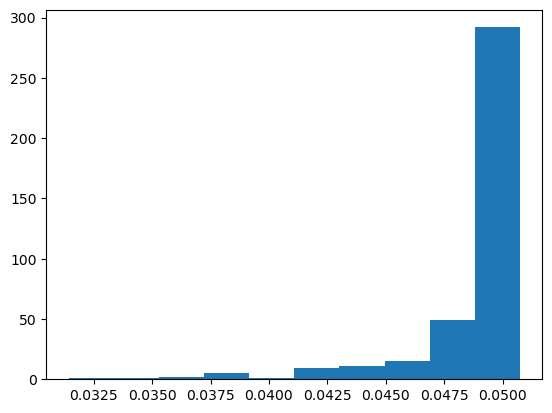

In [17]:
import matplotlib.pyplot as plt
plt.hist(val_period)

In [18]:
0.05*0.85

0.0425

(array([  1.,   1.,   2.,   5.,   1.,   9.,  11.,  15.,  49., 292.]),
 array([0.031446 , 0.0333736, 0.0353012, 0.0372288, 0.0391564, 0.041084 ,
        0.0430116, 0.0449392, 0.0468668, 0.0487944, 0.050722 ]),
 <a list of 10 Patch objects>)

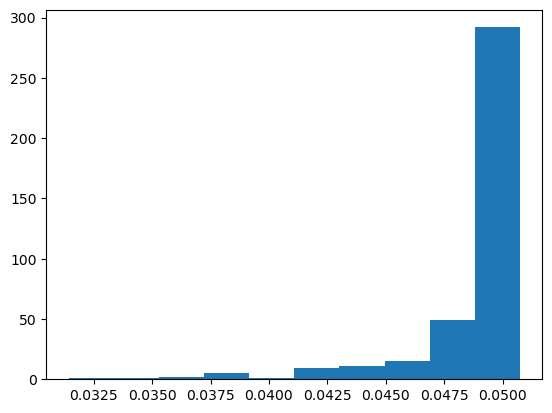

In [19]:
train_period = []

for s_idx in train_idx:
    ts = np.array(samples[s_idx]['events'])[:, 2]
    train_period.append((ts[-1] - ts[0])*1e-9)
    
plt.hist(train_period)

In [20]:
loss_func = torch.nn.L1Loss()
n_epochs = 300
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0005)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr=1e-6, patience=25)

def validate():
    loss = 0
    for i, data in enumerate(val_loader):      
        data = data.to('cuda')
        end_point = model(data)

        loss += loss_func(end_point, data.y).detach().item()
    loss /= len(val_loader)
    return loss

def test():
    loss = 0
    for i, data in enumerate(test_loader):      
        data = data.to('cuda')
        end_point = model(data)

        loss += loss_func(end_point, data.y).detach().item()
    loss /= len(test_loader)
    return loss

In [21]:
from tqdm.auto import trange, tqdm
train_losses = []
val_losses = []
lrs = []



for epoch in trange(n_epochs, desc='training', unit='epoch'):
    val_loss = torch.inf

    if (epoch == 10):
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.001
    
    if epoch == 80:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.0001

    if epoch == 140:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.00001
    
    
    #bunny(epoch)
    epoch_loss = 0
    lr = optimizer.param_groups[0]['lr']
    lrs.append(lr)
    with tqdm(loader, unit="batch", total=len(loader)) as tepoch:
        for i, data in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            with torch.autograd.detect_anomaly():
                data = data.to('cuda')
                optimizer.zero_grad()
                end_point = model(data)
                loss = loss_func(end_point, data.y)
                loss.backward()
                optimizer.step()
                lr = optimizer.param_groups[0]['lr']

                epoch_loss += loss.detach().item()

                tepoch.set_postfix({
                    'train_loss': epoch_loss / (i + 1), 
                    'train_loss_degrees': epoch_loss / (i + 1) * 180/np.pi, 
                    'val_loss': val_losses[epoch - 1] if epoch > 0 else 'na',
                    'val_loss_degrees': val_losses[epoch - 1] * 180/np.pi if epoch > 0 else 'na',
                    'lr': lr
                    })

        #scheduler.step(val_loss)
        epoch_loss /= len(loader)
        val_loss = validate()
        tepoch.set_postfix({'train_loss': epoch_loss, 'val_loss': val_loss})
        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        
 

training:   0%|          | 0/300 [00:00<?, ?epoch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

/tmp/ipykernel_22815/4088217437.py:31: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

  0%|          | 0/193 [00:00<?, ?batch/s]

In [22]:
d.edge_attr

NameError: name 'd' is not defined

In [ ]:
test()

In [ ]:
128*32

In [23]:
g_t

DataBatch(x=[5476, 64], edge_index=[2, 87616], y=[2, 2], pos=[5476, 3], edge_attr=[87616, 3], batch=[5476], ptr=[3])

In [24]:
g_t.batch

tensor([0, 0, 0,  ..., 1, 1, 1], device='cuda:0')